In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
import torch.autograd as autograd
from typing import List
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing


import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scanpy as sc
import time
import os

import scipy

from torch.cuda.amp import GradScaler, autocast

torch.cuda.set_device(0)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
path= "../"
# check available files
# !ls ../real_data

# torch.autograd.set_detect_anomaly(True)

In [2]:
dataset = "simul1_dropout_47_b1_1000_b2_2000"
cellinfo_df = pd.read_csv('%s/cellinfo.txt' % (dataset), sep="\t")
counts_df = pd.read_csv('%s/counts.txt' % (dataset), sep="\t")
de_genes_df = pd.read_csv('%s/de_genes.txt' % (dataset), sep="\t")
geneinfo_df = pd.read_csv('%s/geneinfo.txt' % (dataset), sep="\t")
true_down_genes_df = pd.read_csv('%s/true_down_genes.txt' % (dataset), sep="\t")
true_up_genes_df = pd.read_csv('%s/true_up_genes.txt' % (dataset), sep="\t")

from anndata import AnnData

adata = AnnData(X=counts_df.transpose(), obs=cellinfo_df.iloc[:, 1:],
                    dtype='float32')

# obs_label_colname ="celltype"
adata

le = preprocessing.LabelEncoder()
new_batch = le.fit_transform(adata.obs["Batch"])
adata.obs["Batch"] = new_batch

new_batch = [str(each) for each in new_batch]
adata.obs["Batch_num"] = new_batch

# change also for the groups we want to preserve
le_2 = preprocessing.LabelEncoder()
new_groups = le_2.fit_transform(adata.obs["Group"])
new_groups = [int(each) for each in new_groups]
# new_groups = [str(each) for each in new_groups]
adata.obs["Group"] = new_groups

adata.obs["Group_num"] = le_2.inverse_transform(adata.obs['Group'])
adata.obs["Group_num"] = [str(each) for each in adata.obs["Group_num"]]

In [3]:
adata.layers["counts"] = adata.X

In [4]:
# flavor: seurat_v3, cell_ranger & log = false
def sub_data_preprocess(adata: sc.AnnData, n_top_genes: int = 5000, batch_key: str = None, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3) -> sc.AnnData:
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
#     if flavor == 'seurat_v3':
# # #         count data is expected when flavor=='seurat_v3'
# #         sc.pp.highly_variable_genes(
# #             adata, flavor=flavor, batch_key = batch_key)
#         sc.pp.highly_variable_genes(
#             adata, flavor=flavor, batch_key = batch_key, n_top_genes=n_top_genes)

#     if flavor != 'seurat_v3':.
#         # log-format data is expected when flavor!='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, n_top_genes=n_top_genes, flavor=flavor)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    return adata


def data_preprocess(adata: sc.AnnData, key: str = 'batch', n_top_genes: int = 10000, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3, n_batch: int = 2) -> sc.AnnData:
    print('Establishing Adata for Next Step...')
    hv_adata = sub_data_preprocess(adata, n_top_genes=n_top_genes, batch_key = key, flavor=flavor, min_genes=min_genes, min_cells=min_cells)
#     if len(adata.var.index) > n_top_genes:
#         hv_adata = hv_adata[:, hv_adata.var['highly_variable']]
#     hv_adata.X = np.expm1(hv_adata.X)
    print('PreProcess Done.')
    return hv_adata

In [5]:
batch_str = "Batch"

adata = data_preprocess(adata, batch_str)
adata  # Output the basic information of the preprocessed data.

Establishing Adata for Next Step...
PreProcess Done.


AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [6]:
adata.layers["log_norm"] = adata.X

In [7]:
label_str = "Batch"

# split per batch into new objects.
batches = list(set(adata.obs[label_str]))
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs[label_str] == batch,]

length_data = []

for batch in batches:
    length = len(alldata[batch])
    
    length_data.append(length)
    
# getting the batch with the most number of cell to be the anchoring/reference batch
anchor_index = np.argmax(length_data)

print(batches[anchor_index])

3


In [8]:
adata.obs["Batch"]

Cell1       0
Cell2       0
Cell3       0
Cell4       0
Cell5       0
           ..
Cell7995    3
Cell7997    3
Cell7998    3
Cell7999    3
Cell8000    3
Name: Batch, Length: 7891, dtype: int64

### pre processing step for normalise and scale the for each individual batch

In [9]:
# # apply the pre processing onto the anndata
# # first create layer for the anndata

adata.layers["X_raw"] = adata.layers["log_norm"]

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

Global seed set to 0


In [65]:
adata = adata.copy()

# scVI take raw count data as the input and using it on pancreatic dataset might not be a good option
# however, it is better to use it than not being able to use it.

scvi.model.SCVI.setup_anndata(adata, batch_key="Batch", layer = "counts")

# the key is to change to zinb for simulation data 5
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=10, gene_likelihood="nb")

In [170]:
vae.train(batch_size = 128)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|██████████| 400/400 [04:48<00:00,  1.39it/s, loss=2.21e+03, v_num=1]


In [171]:
vae.get_reconstruction_error()

{'reconstruction_loss': -2168.9634413414014}

In [172]:
output_results = vae.get_normalized_expression(transform_batch = 0, n_samples = 1, library_size=10000).values

In [173]:
output_results = np.log1p(output_results)
output_results

array([[1.1193603e-06, 3.3651708e-07, 3.3793974e-01, ..., 6.9540761e-02,
        2.8436743e-03, 2.6075520e-02],
       [5.2662813e-08, 1.0133224e-11, 1.4748701e-02, ..., 3.6625183e-04,
        2.8748233e-03, 1.6618729e-02],
       [3.1071850e-05, 3.9115580e-06, 3.4008313e-02, ..., 1.2171723e-01,
        6.7146886e-03, 1.1264350e-01],
       ...,
       [6.7787405e-05, 7.3975620e-10, 4.0117219e-02, ..., 7.3338413e-01,
        2.4745893e-04, 3.4575476e-03],
       [6.5182303e-07, 7.7177233e-08, 7.5414650e-02, ..., 7.2717005e-01,
        4.7984393e-04, 3.0373307e-02],
       [3.7688274e-06, 1.9793253e-08, 5.2208096e-02, ..., 9.4033172e-03,
        1.0039615e-02, 1.5235418e-01]], dtype=float32)

In [174]:
np.amax(output_results)

7.9455

In [175]:
# # Time the scVI with library size
# output_results = np.log1p(output_results * adata.obs.ExpLibSize.values.reshape(-1, 1))

In [176]:
# output_results = np.log1p(output_results)

In [177]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [178]:
adata

AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'louvain'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'Batch_num_colors', 'Group_num_colors', 'louvain'
    obsm: 'X_scVI', 'X_latent', 'X_pca', 'X_umap'
    layers: 'counts', 'log_norm', 'X_raw'
    obsp: 'distances', 'connectivities'

In [179]:
# import scipy.special
# from sklearn.metrics.cluster import adjusted_rand_score


# def ari(adata, group1, group2, implementation="sklearn"):
#     """Adjusted Rand Index
#     The function is symmetric, so group1 and group2 can be switched
#     For single cell integration evaluation the comparison is between predicted cluster
#     assignments and the ground truth (e.g. cell type)
#     :param adata: anndata object
#     :param group1: string of column in adata.obs containing labels
#     :param group2: string of column in adata.obs containing labels
#     :param implementation: if set to 'sklearn', uses sklearn's implementation,
#         otherwise native implementation is taken
#     """

#     group1 = adata.obs[group1].to_numpy()
#     group2 = adata.obs[group2].to_numpy()

#     if len(group1) != len(group2):
#         raise ValueError(
#             f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
#         )

#     return adjusted_rand_score(group1, group2)

# resolutions = None

# if resolutions is None:
#     n = 20
#     resolutions = [2 * x / n for x in range(1, n + 1)]

# score_max = 0
# res_max = resolutions[0]
# clustering = None
# score_all = []
# use_rep = "X_pca"
# cluster_key = "louvain"
# label_key = "celltype"

# try:
#     adata.uns["neighbors"]
# except KeyError:
#     if verbose:
#         print("computing neighbours for opt_cluster")
#     sc.pp.neighbors(adata, use_rep=use_rep)
    
# for res in resolutions:
#     sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
#     score = ari(adata, label_key, cluster_key)
#     score_all.append(score)
#     if score_max < score:
#         score_max = score
#         res_max = res
#         clustering = adata.obs[cluster_key]
        
# score_max

In [180]:
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=["celltype"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [181]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=150, frameon=False, figsize=(3, 3), facecolor='white')

In [182]:
from sklearn.decomposition import PCA

adata.obsm["X_latent"] = output_results.copy()

# output_results_norm = sc.pp.normalize_per_cell(output_results, counts_per_cell_after = 1e4, copy = True)
# output_results_log_norm = sc.pp.log1p(output_results_norm)
# output_results_scaled = sc.pp.scale(output_results_log_norm)
# output_results_scaled = sc.pp.scale(output_results, copy = True)

# adata.obsm["X_latent_norm"] = output_results_log_norm
# adata.obsm["X_latent_scaled"] = output_results_scaled.copy()

pca = PCA(n_components = 50, random_state = 8)

# pca.fit(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# X_pca = pca.transform(sc.pp.scale(adata.obsm["X_latent"], copy = True))

pca.fit(output_results)

X_pca = pca.transform(output_results)

adata.obsm["X_pca"] = X_pca.copy()

In [183]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(adata)

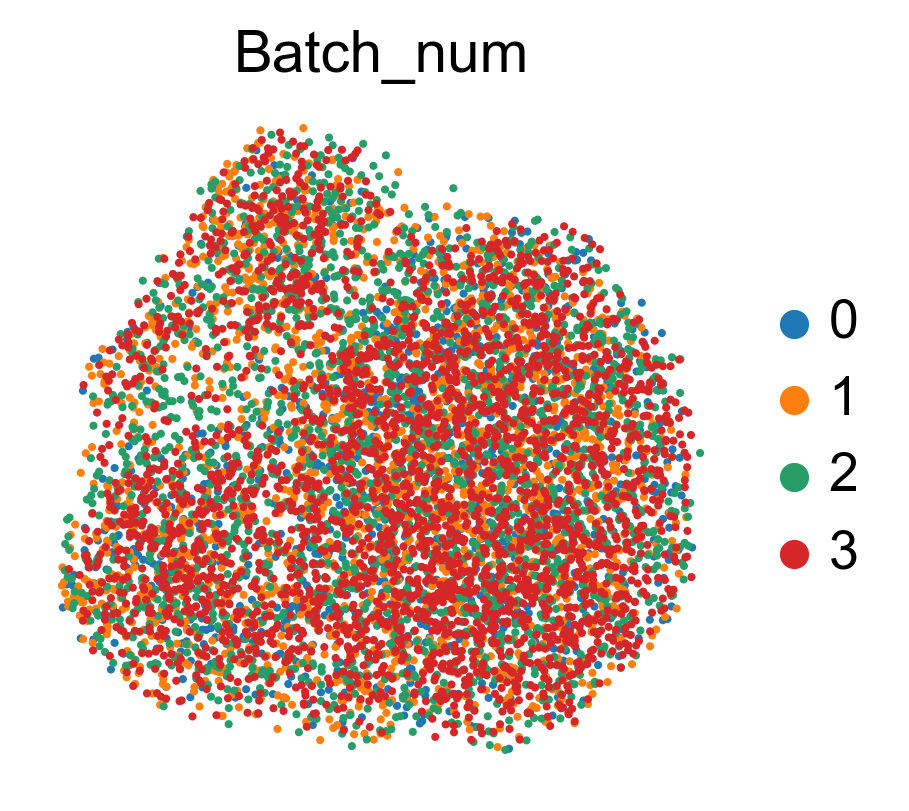

In [184]:
sc.pl.umap(adata, color=['Batch_num'],
           palette=sc.pl.palettes.vega_20_scanpy)

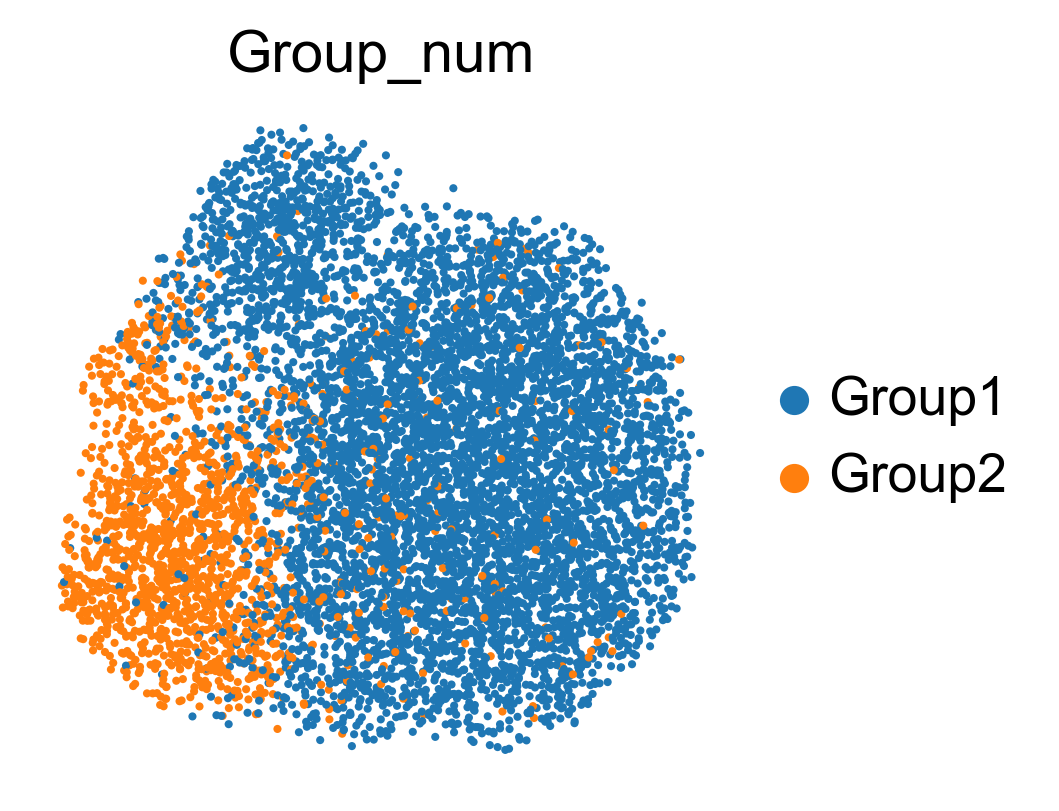

In [185]:
sc.pl.umap(adata, color=["Group_num"],
           palette=sc.pl.palettes.vega_20_scanpy)

In [186]:
# sc.pl.umap(adata, color=["Method", "CellType"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [187]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

resolutions = None

if resolutions is None:
    n = 20
    resolutions = [2 * x / n for x in range(1, n + 1)]

score_max = 0
res_max = resolutions[0]
clustering = None
score_all = []
use_rep = "X_pca"
cluster_key = "louvain"
label_key = "Group"

sc.pp.neighbors(adata, use_rep=use_rep)
    
for res in resolutions:
    sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
    score = ari(adata, label_key, cluster_key)
    score_all.append(score)
    if score_max < score:
        score_max = score
        res_max = res
        clustering = adata.obs[cluster_key]
        
score_max

0.4651357577754258

In [188]:
# test_df = pd.DataFrame(output_results)
# sum(test_df.iloc[0,:])

## get only the latent space of the scVI and projecting it into the UMAP

In [189]:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html

In [190]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [191]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors = 30)
sc.tl.umap(adata)
# sc.pl.umap(adata, color=['batch', 'CellType'],
#            palette=sc.pl.palettes.vega_20_scanpy)

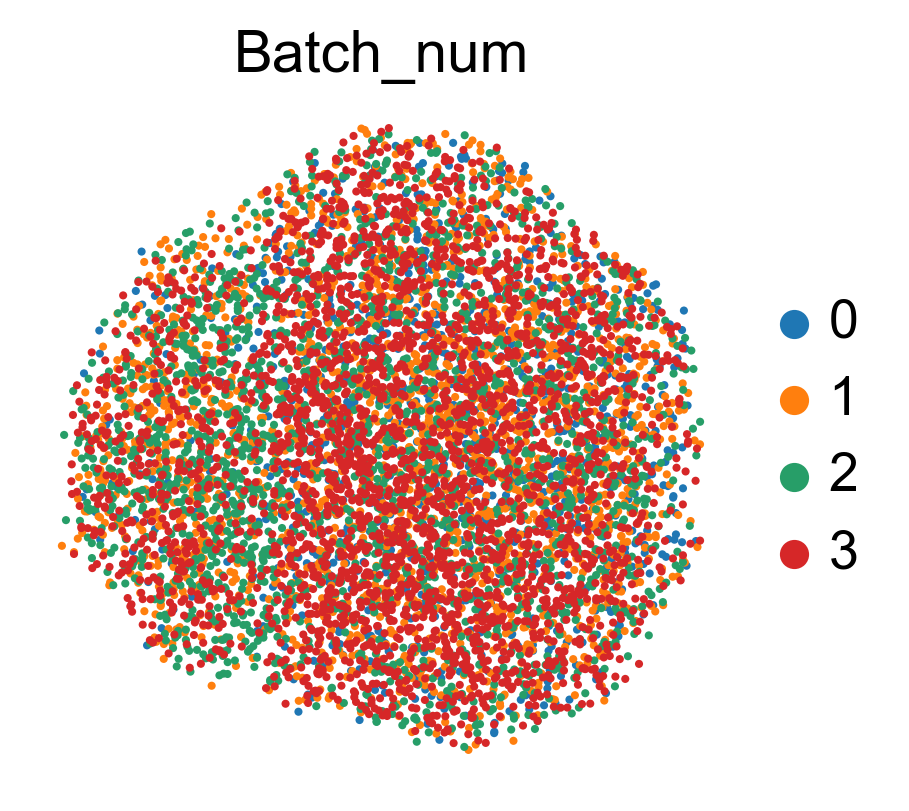

In [192]:
sc.pl.umap(adata, color=['Batch_num'],
           palette=sc.pl.palettes.vega_20_scanpy)

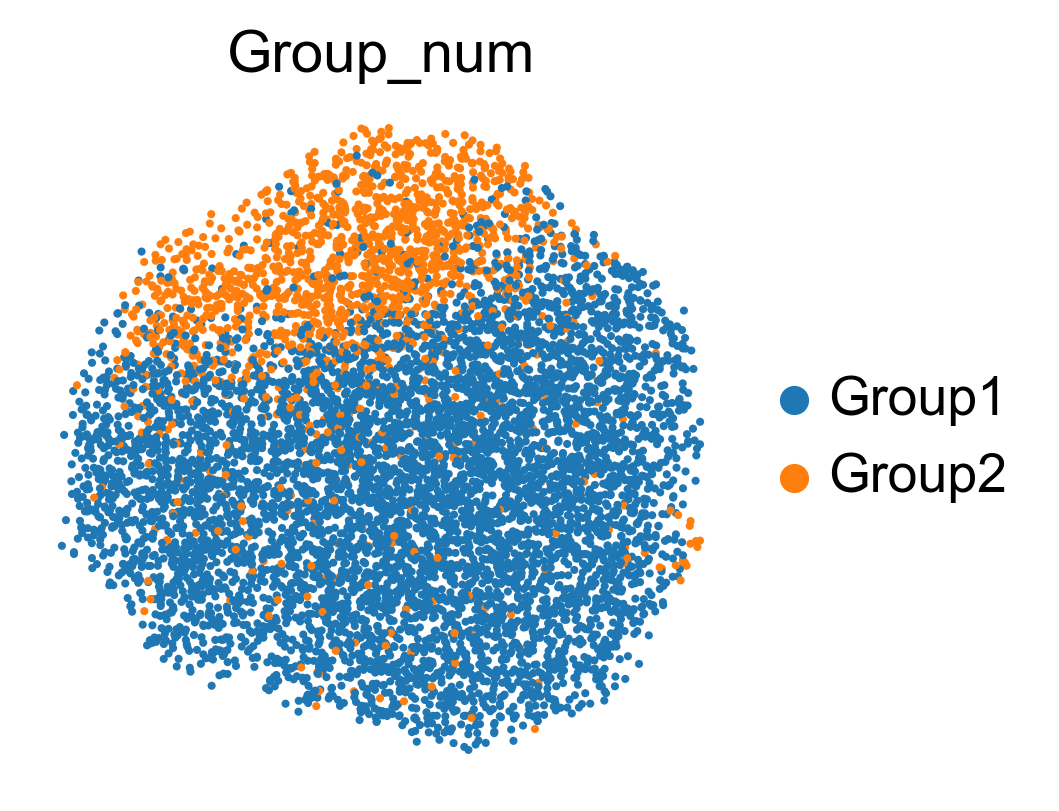

In [193]:
sc.pl.umap(adata, color=["Group_num"],
           palette=sc.pl.palettes.vega_20_scanpy)

In [194]:
adata.write_h5ad("scVI_simulation_1.h5ad")

In [195]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

resolutions = None

if resolutions is None:
    n = 20
    resolutions = [2 * x / n for x in range(1, n + 1)]

score_max = 0
res_max = resolutions[0]
clustering = None
score_all = []
use_rep = "X_pca"
cluster_key = "louvain"
label_key = "Group"

try:
    adata.uns["neighbors"]
except KeyError:
    if verbose:
        print("computing neighbours for opt_cluster")
    sc.pp.neighbors(adata, use_rep=use_rep)
    
for res in resolutions:
    sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
    score = ari(adata, label_key, cluster_key)
    score_all.append(score)
    if score_max < score:
        score_max = score
        res_max = res
        clustering = adata.obs[cluster_key]
        
score_max

0.03572297486931803